In [1]:
import yfinance as yf
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ta as ta

In [2]:
#Definir ticket de ETFs
ticket_vanguardSP500 = yf.Ticker("VOO")



In [3]:

def descargar_y_limpiar_ticker(ticker: str, start=None, end=None, interval='1d') -> pd.DataFrame:
    """
    Descarga y limpia datos históricos de un ticker con yfinance.
    
    Args:
        ticker (str): Símbolo del ticker (ej: 'VOO', '^GSPC')
        start (str): Fecha de inicio 'YYYY-MM-DD'
        end (str): Fecha de fin 'YYYY-MM-DD'
        interval (str): Intervalo temporal ('1d', '1wk', etc.)
        
    Returns:
        pd.DataFrame: DataFrame limpio con columnas estandarizadas.
    """
    df = yf.download(
        tickers=ticker,
        start=start,
        end=end,
        interval=interval,
        auto_adjust=True,
        progress=False
    )
    

  
    if isinstance(df.columns, pd.MultiIndex):             # Si las columnas del DataFrame son un MultiIndex (por ejemplo, tras descargar datos con varias series),
        df.columns = df.columns.droplevel(1)              # se elimina el segundo nivel del MultiIndex para simplificar.
        df.columns = df.columns.get_level_values(0)       # se selecciona solo el primer nivel de nombres de columna para simplificar el DataFrame.
    
    df = df.reset_index()
    df.rename(columns={"Date": "date"}, inplace=True)
    df['date'] = pd.to_datetime(df['date'])
    df.columns = [col.lower() for col in df.columns]
    df = df.sort_values('date')                           # Asegurarse de que los datos están ordenados por fecha
    df = df.round(3)                                       #Redondear los valores float a 3 decimales
    
    # Asegurarse de que las columnas necesarias están presentes
    cols_esperadas = {'open', 'high', 'low', 'close', 'volume'}
    if not cols_esperadas.issubset(df.columns):
        raise ValueError(f"Faltan columnas necesarias en {ticker}: {cols_esperadas - set(df.columns)}")
    
    return df



In [4]:
#Descarga de datos y exportar a csv 

df_voo = descargar_y_limpiar_ticker("VOO", start="2010-01-01",end = "2025-04-01", interval='1d')
df_voo['date'] = pd.to_datetime(df_voo['date'])
df_voo.to_csv('df_voo.csv', index=False)


In [5]:
# Comprobaciones de tipos de datos 
print(df_voo.dtypes)

date      datetime64[ns]
close            float64
high             float64
low              float64
open             float64
volume             int64
dtype: object


In [6]:
print(df_voo.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3662 entries, 0 to 3661
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    3662 non-null   datetime64[ns]
 1   close   3662 non-null   float64       
 2   high    3662 non-null   float64       
 3   low     3662 non-null   float64       
 4   open    3662 non-null   float64       
 5   volume  3662 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 171.8 KB
None


In [11]:
import plotly.graph_objects as go

rsi = df_voo['rsi']
dates = df_voo['date']
close = df_voo['close']

buy_signals = []
sell_signals = []

for i in range(1, len(rsi)):
    if rsi[i-1] < 30 and rsi[i] >= 30:
        buy_signals.append((dates[i], close[i]))
    elif rsi[i-1] > 70 and rsi[i] <= 70:
        sell_signals.append((dates[i], close[i]))

fig = go.Figure()

# Precio de cierre
fig.add_trace(go.Scatter(x=dates, y=close, mode='lines', name='Precio de Cierre'))

# Señales de compra (flechas verdes arriba)
if buy_signals:
    buy_dates, buy_prices = zip(*buy_signals)
    fig.add_trace(go.Scatter(
        x=buy_dates, y=buy_prices,
        mode='markers',
        marker=dict(symbol='triangle-up', color='green', size=12),
        name='Señal Compra'
    ))

# Señales de venta (flechas rojas abajo)
if sell_signals:
    sell_dates, sell_prices = zip(*sell_signals)
    fig.add_trace(go.Scatter(
        x=sell_dates, y=sell_prices,
        mode='markers',
        marker=dict(symbol='triangle-down', color='red', size=12),
        name='Señal Venta'
    ))

# Gráfico RSI debajo, en subplot
from plotly.subplots import make_subplots

fig_subplots = make_subplots(rows=2, cols=1, shared_xaxes=True,
                             vertical_spacing=0.1,
                             row_heights=[0.7, 0.3],
                             subplot_titles=("Precio de Cierre de VOO con señales RSI", "Índice de Fuerza Relativa (RSI)"))

# Precio + señales en fila 1
fig_subplots.add_trace(go.Scatter(x=dates, y=close, mode='lines', name='Precio de Cierre'), row=1, col=1)

if buy_signals:
    fig_subplots.add_trace(go.Scatter(
        x=buy_dates, y=buy_prices,
        mode='markers',
        marker=dict(symbol='triangle-up', color='green', size=12),
        name='Señal Compra'), row=1, col=1)

if sell_signals:
    fig_subplots.add_trace(go.Scatter(
        x=sell_dates, y=sell_prices,
        mode='markers',
        marker=dict(symbol='triangle-down', color='red', size=12),
        name='Señal Venta'), row=1, col=1)

# RSI en fila 2
fig_subplots.add_trace(go.Scatter(x=dates, y=rsi, mode='lines', line_color='orange', name='RSI'), row=2, col=1)
fig_subplots.add_hline(y=70, line_dash="dash", line_color="red", row=2, col=1)
fig_subplots.add_hline(y=30, line_dash="dash", line_color="green", row=2, col=1)

fig_subplots.update_yaxes(title_text="Precio", row=1, col=1)
fig_subplots.update_yaxes(title_text="RSI", row=2, col=1)
fig_subplots.update_xaxes(title_text="Fecha", row=2, col=1)

fig_subplots.update_layout(height=700, width=900, showlegend=True)
fig_subplots.show()




In [ ]:
import plotly.graph_objects as go
import numpy as np



# Detectar señales de compra y venta (cruce de MACD y MACD Signal)
df_voo['macd_diff'] = df_voo['macd'] - df_voo['macd_signal']
df_voo['signal_buy'] = (df_voo['macd_diff'] > 0) & (df_voo['macd_diff'].shift(1) <= 0)
df_voo['signal_sell'] = (df_voo['macd_diff'] < 0) & (df_voo['macd_diff'].shift(1) >= 0)

fig = go.Figure()

# Precio de cierre
fig.add_trace(go.Scatter(x=df_voo['date'], y=df_voo['close'], mode='lines', name='Precio de Cierre'))

# MACD y MACD Signal (opcional para ver el cruce)
fig.add_trace(go.Scatter(x=df_voo['date'], y=df_voo['macd'], mode='lines', name='MACD', line=dict(color='blue', width=1), yaxis='y2'))
fig.add_trace(go.Scatter(x=df_voo['date'], y=df_voo['macd_signal'], mode='lines', name='MACD Signal', line=dict(color='orange', width=1), yaxis='y2'))

# Señales de compra (puntos verdes)
fig.add_trace(go.Scatter(
    x=df_voo.loc[df_voo['signal_buy'], 'date'],
    y=df_voo.loc[df_voo['signal_buy'], 'close'],
    mode='markers',
    name='Señal Compra',
    marker=dict(color='green', size=10, symbol='triangle-up')
))

# Señales de venta (puntos rojos)
fig.add_trace(go.Scatter(
    x=df_voo.loc[df_voo['signal_sell'], 'date'],
    y=df_voo.loc[df_voo['signal_sell'], 'close'],
    mode='markers',
    name='Señal Venta',
    marker=dict(color='red', size=10, symbol='triangle-down')
))

# Layout para dos ejes y (precio y MACD)
fig.update_layout(
    title='Precio de Cierre con Señales MACD',
    yaxis=dict(title='Precio de Cierre'),
    yaxis2=dict(title='MACD', overlaying='y', side='right', showgrid=False),
    xaxis=dict(title='Fecha'),
    legend=dict(x=0, y=1.1, orientation='h')
)

fig.show()


In [15]:
operaciones_long, operaciones_short = simular_estrategia_macd(df_voo)


Operaciones Long: 153, Ganancia/pérdida total Long: 102.17 €
Operaciones Short: 152, Ganancia/pérdida total Short: -91.06 €
Total neto: 11.11 €


In [20]:
# Asegurarse de que los valores de RSI están completos
df_voo = df_voo.copy()
df_voo = df_voo.dropna(subset=['rsi'])

# Crear señales de entrada para estrategia RSI
df_voo['long_signal'] = (df_voo['rsi'] > 30) & (df_voo['rsi'].shift(1) <= 30)
df_voo['short_signal'] = (df_voo['rsi'] < 70) & (df_voo['rsi'].shift(1) >= 70)

# Inicializar variables
capital_inicial = 1000
capital_long = capital_inicial
capital_short = capital_inicial
position = None  # puede ser 'long', 'short', o None
entry_price = 0

# Contadores
long_trades = 0
short_trades = 0

# Historial de operaciones
operaciones = []

# Recorrer el DataFrame
for i in range(len(df_voo)):
    row = df_voo.iloc[i]
    precio = row['close']
    
    if position is None:
        # Entrada long
        if row['long_signal']:
            position = 'long'
            entry_price = precio
            long_trades += 1
        
        # Entrada short
        elif row['short_signal']:
            position = 'short'
            entry_price = precio
            short_trades += 1

    elif position == 'long':
        # Salir si RSI > 70
        if row['rsi'] > 70:
            ganancia = ((precio - entry_price) / entry_price) * capital_long
            operaciones.append({'tipo': 'long', 'entrada': entry_price, 'salida': precio, 'ganancia': ganancia})
            capital_long += ganancia
            position = None

    elif position == 'short':
        # Salir si RSI < 30
        if row['rsi'] < 30:
            ganancia = ((entry_price - precio) / entry_price) * capital_short
            operaciones.append({'tipo': 'short', 'entrada': entry_price, 'salida': precio, 'ganancia': ganancia})
            capital_short += ganancia
            position = None

# Resultados finales
ganancia_total_long = capital_long - capital_inicial
ganancia_total_short = capital_short - capital_inicial

print(f"Operaciones Long: {long_trades}, Ganancia/pérdida total Long: {ganancia_total_long:.2f} €")
print(f"Operaciones Short: {short_trades}, Ganancia/pérdida total Short: {ganancia_total_short:.2f} €")
print(f"Ganancia/Pérdida Total: {ganancia_total_long + ganancia_total_short:.2f} €")
print(f"porcentaje de aciertos Long: {long_trades / (long_trades + short_trades) * 100:.2f}%")


Operaciones Long: 14, Ganancia/pérdida total Long: 1452.48 €
Operaciones Short: 14, Ganancia/pérdida total Short: -697.04 €
Ganancia/Pérdida Total: 755.44 €
porcentaje de aciertos Long: 50.00%


Capital total invertido: 292200.00 €
Valor final del portfolio: 792327.42 €
Ganancia/Pérdida: 500127.42 €


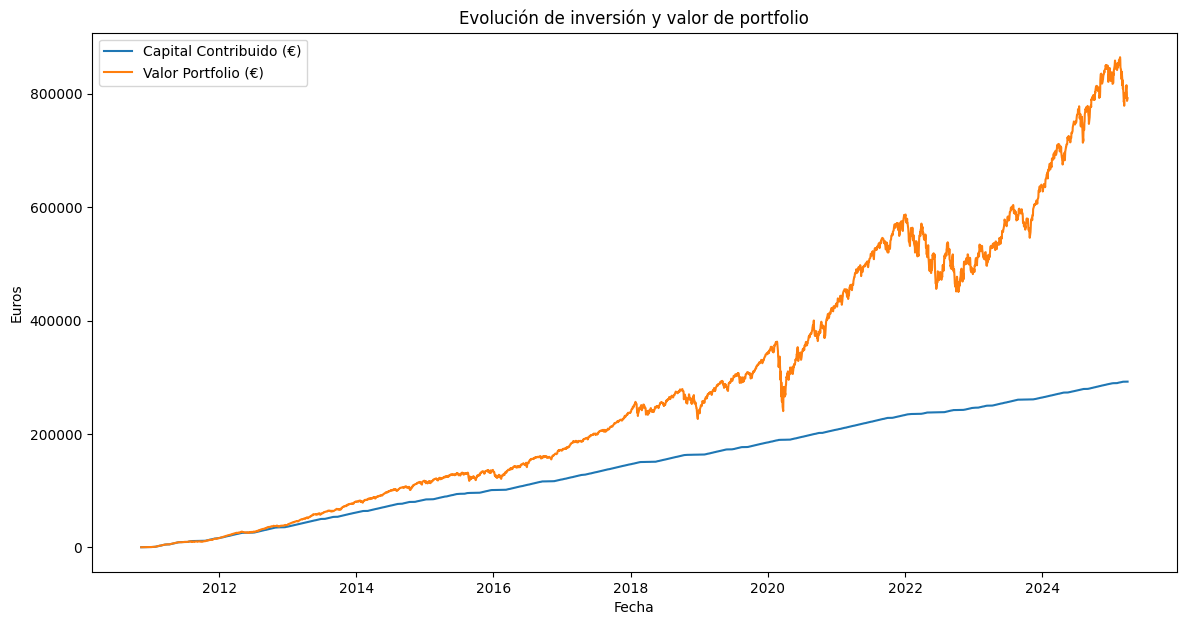

In [ ]:
import pandas as pd
import numpy as np



# Crear señales de compra (1 cuando SMA20 > SMA50)
df_voo['signal'] = 0
df_voo.loc[df_voo['sma_20'] > df_voo['sma_50'], 'signal'] = 1

# Añadir columna para control de inversión y valor acumulado
df_voo = df_voo.sort_values('date').reset_index(drop=True)
df_voo['investment'] = 0.0       # € invertidos ese día
df_voo['shares'] = 0.0           # Número de acciones compradas ese día
df_voo['cumulative_shares'] = 0.0  # Acumulado de acciones
df_voo['capital_contribuido'] = 0.0  # Total € invertidos hasta la fecha
df_voo['portfolio_value'] = 0.0      # Valor total de las acciones a precio cierre

# Variables auxiliares
capital_total = 0.0
shares_total = 0.0
last_investment_day = None

# Parámetros inversión
inversion_entrada = 100   # € inversión en cada señal de compra
aporte_semanal = 50       # € aportado cada 7 días

# Iterar sobre las filas
for i, row in df_voo.iterrows():
    date = row['date']
    price = row['close']

    # Aportación semanal: cada 7 días desde la última aportación (si existe)
    if last_investment_day is None or (date - last_investment_day).days >= 7:
        # Aporte recurrente de 100 €
        shares_to_buy = aporte_semanal / price
        shares_total += shares_to_buy
        capital_total += aporte_semanal
        df_voo.at[i, 'investment'] += aporte_semanal
        df_voo.at[i, 'shares'] += shares_to_buy
        last_investment_day = date

    # Inversión adicional si hay señal de compra (y no fue en mismo día que aporte semanal)
    if row['signal'] == 1 and df_voo.at[i, 'investment'] < inversion_entrada:
        # Añadimos inversión extra de 1000€
        shares_to_buy = inversion_entrada / price
        shares_total += shares_to_buy
        capital_total += inversion_entrada
        df_voo.at[i, 'investment'] += inversion_entrada
        df_voo.at[i, 'shares'] += shares_to_buy

    df_voo.at[i, 'cumulative_shares'] = shares_total
    df_voo.at[i, 'capital_contribuido'] = capital_total
    df_voo.at[i, 'portfolio_value'] = shares_total * price

# Mostrar evolución final
print(f"Capital total invertido: {capital_total:.2f} €")
print(f"Valor final del portfolio: {df_voo['portfolio_value'].iloc[-1]:.2f} €")
print(f"Ganancia/Pérdida: {df_voo['portfolio_value'].iloc[-1] - capital_total:.2f} €")




Capital total invertido: 473800.00 €
Valor final del portfolio: 1322410.81 €
Ganancia/Pérdida: 848610.81 €


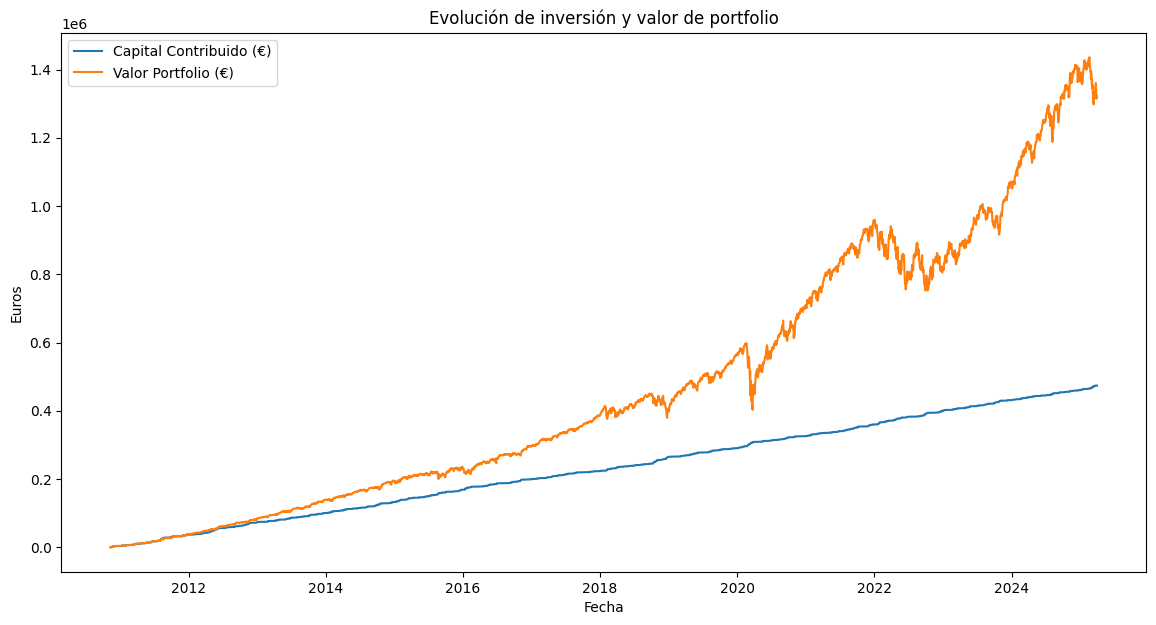

In [32]:
import numpy as np
import matplotlib.pyplot as plt

df_voo = df_voo.sort_values('date').reset_index(drop=True)

# Señales basadas en RSI, MACD y Stocástico

# RSI: señal de compra cuando RSI <= 30 (sobreventa)
df_voo['signal_rsi'] = np.where(df_voo['rsi'] <= 30, 1, 0)

# MACD: señal de compra cuando MACD cruza por encima de MACD_signal
df_voo['macd_diff'] = df_voo['macd'] - df_voo['macd_signal']
df_voo['signal_macd'] = ((df_voo['macd_diff'].shift(1) < 0) & (df_voo['macd_diff'] > 0)).astype(int)

# Estocástico: señal de compra cuando %K cruza por encima de 20 (sobreventa)
df_voo['stoch_k_diff'] = df_voo['stochastic_k'] - 20
df_voo['signal_stoch'] = ((df_voo['stoch_k_diff'].shift(1) < 0) & (df_voo['stoch_k_diff'] > 0)).astype(int)

# Combinamos señales (OR lógico) para una señal de compra general
df_voo['signal'] = df_voo[['signal_rsi', 'signal_macd', 'signal_stoch']].max(axis=1)

# Inicializamos columnas de inversión y seguimiento
df_voo['investment'] = 0.0
df_voo['shares'] = 0.0
df_voo['cumulative_shares'] = 0.0
df_voo['capital_contribuido'] = 0.0
df_voo['portfolio_value'] = 0.0

capital_total = 0.0
shares_total = 0.0
last_investment_day = None

inversion_entrada = 1000  # inversión inicial en señal
aporte_semanal = 100      # aporte semanal fijo

for i, row in df_voo.iterrows():
    date = row['date']
    price = row['close']

    # Aporte semanal fijo cada 7 días
    if last_investment_day is None or (date - last_investment_day).days >= 7:
        shares_to_buy = aporte_semanal / price
        shares_total += shares_to_buy
        capital_total += aporte_semanal
        df_voo.at[i, 'investment'] += aporte_semanal
        df_voo.at[i, 'shares'] += shares_to_buy
        last_investment_day = date

    # Inversión adicional si hay señal de compra (y no fue en mismo día que aporte semanal)
    if row['signal'] == 1 and df_voo.at[i, 'investment'] < inversion_entrada:
        shares_to_buy = inversion_entrada / price
        shares_total += shares_to_buy
        capital_total += inversion_entrada
        df_voo.at[i, 'investment'] += inversion_entrada
        df_voo.at[i, 'shares'] += shares_to_buy

    df_voo.at[i, 'cumulative_shares'] = shares_total
    df_voo.at[i, 'capital_contribuido'] = capital_total
    df_voo.at[i, 'portfolio_value'] = shares_total * price

print(f"Capital total invertido: {capital_total:.2f} €")
print(f"Valor final del portfolio: {df_voo['portfolio_value'].iloc[-1]:.2f} €")
print(f"Ganancia/Pérdida: {df_voo['portfolio_value'].iloc[-1] - capital_total:.2f} €")

# Graficar evolución
plt.figure(figsize=(14, 7))
plt.plot(df_voo['date'], df_voo['capital_contribuido'], label='Capital Contribuido (€)')
plt.plot(df_voo['date'], df_voo['portfolio_value'], label='Valor Portfolio (€)')
plt.title('Evolución de inversión y valor de portfolio')
plt.xlabel('Fecha')
plt.ylabel('Euros')
plt.legend()
plt.show()


In [34]:
# RSI: comprar cuando RSI < 30, vender cuando RSI > 70
df_voo['rsi_signal'] = 0
df_voo.loc[df_voo['rsi'] < 30, 'rsi_signal'] = 1

# MACD: comprar cuando MACD cruza arriba MACD_signal, vender cuando cruza abajo
df_voo['macd_signal_bin'] = 0
macd = df_voo['macd']
macd_signal = df_voo['macd_signal']
df_voo.loc[(macd > macd_signal) & (macd.shift(1) <= macd_signal.shift(1)), 'macd_signal_bin'] = 1
df_voo.loc[(macd < macd_signal) & (macd.shift(1) >= macd_signal.shift(1)), 'macd_signal_bin'] = -1

# Estocástico: comprar cuando %K cruza arriba %D (stochastic_k y stochastic_d), vender cuando cruza abajo
df_voo['stochastic_signal'] = 0
df_voo.loc[(df_voo['stochastic_k'] > df_voo['stochastic_d']) & (df_voo['stochastic_k'].shift(1) <= df_voo['stochastic_d'].shift(1)), 'stochastic_signal'] = 1
df_voo.loc[(df_voo['stochastic_k'] < df_voo['stochastic_d']) & (df_voo['stochastic_k'].shift(1) >= df_voo['stochastic_d'].shift(1)), 'stochastic_signal'] = -1


In [35]:
import numpy as np

df_voo = df_voo.sort_values('date').reset_index(drop=True)

# Crear señal combinada
def combinacion_senales(row):
    signals = [row['rsi_signal'], row['macd_signal_bin'], row['stochastic_signal']]
    buy_signals = sum(1 for s in signals if s == 1)
    sell_signals = sum(1 for s in signals if s == -1)
    if buy_signals >= 2:
        return 1  # Comprar
    elif sell_signals >= 2:
        return -1  # Vender
    else:
        return 0  # Mantener

df_voo['combined_signal'] = df_voo.apply(combinacion_senales, axis=1)

# Inicializar variables de backtesting
capital = 10000  # Capital inicial
position = 0     # 0 = sin posición, 1 = posición larga
shares = 0
portfolio_value = []
cash = capital

for i, row in df_voo.iterrows():
    price = row['close']
    signal = row['combined_signal']
    
    # Comprar
    if signal == 1 and position == 0:
        shares = cash / price  # comprar todas las acciones posibles
        cash = 0
        position = 1
        #print(f"Compra en {row['date'].date()} a {price:.2f}")
        
    # Vender
    elif signal == -1 and position == 1:
        cash = shares * price
        shares = 0
        position = 0
        #print(f"Venta en {row['date'].date()} a {price:.2f}")
        
    # Valor portfolio = cash + valor acciones
    portfolio_value.append(cash + shares * price)

df_voo['portfolio_value'] = portfolio_value

# Resultados
print(f"Capital inicial: {capital} €")
print(f"Capital final: {portfolio_value[-1]:.2f} €")
print(f"Rentabilidad: {(portfolio_value[-1] - capital) / capital * 100:.2f} %")


Capital inicial: 10000 €
Capital final: 23427.45 €
Rentabilidad: 134.27 %


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def invertir_largo_plazo(df, inversion_fuerte=1000, aporte_semanal=100):
    """
    Simula una estrategia de inversión a largo plazo con:
    - inversión fuerte puntual (ej. 1000€) cuando hay señal de compra (signal==1)
    - aporte semanal constante (ej. 100€)
    - sin ventas, solo acumulación de acciones

    Args:
        df (pd.DataFrame): DataFrame ordenado por fecha y con columnas ['date', 'close', 'signal']
        inversion_fuerte (float): € a invertir cuando hay señal de compra
        aporte_semanal (float): € a invertir cada semana

    Returns:
        pd.DataFrame: DataFrame con columnas para inversión y patrimonio
    """

    df = df.sort_values('date').reset_index(drop=True)

    df['investment'] = 0.0       # € invertidos ese día
    df['shares'] = 0.0           # acciones compradas ese día
    df['cumulative_shares'] = 0.0
    df['capital_contribuido'] = 0.0
    df['portfolio_value'] = 0.0

    shares_total = 0.0
    capital_total = 0.0
    last_aporte_date = None

    for i, row in df.iterrows():
        date = row['date']
        price = row['close']

        # Aporte semanal constante
        if last_aporte_date is None or (date - last_aporte_date).days >= 7:
            shares = aporte_semanal / price
            shares_total += shares
            capital_total += aporte_semanal
            df.at[i, 'investment'] += aporte_semanal
            df.at[i, 'shares'] += shares
            last_aporte_date = date

        # Inversión fuerte si señal de compra
        if row.get('signal', 0) == 1:
            shares = inversion_fuerte / price
            shares_total += shares
            capital_total += inversion_fuerte
            df.at[i, 'investment'] += inversion_fuerte
            df.at[i, 'shares'] += shares

        df.at[i, 'cumulative_shares'] = shares_total
        df.at[i, 'capital_contribuido'] = capital_total
        df.at[i, 'portfolio_value'] = shares_total * price

    print(f"Capital total invertido: {capital_total:.2f} €")
    print(f"Valor final del portfolio: {df['portfolio_value'].iloc[-1]:.2f} €")
    print(f"Ganancia/Pérdida: {df['portfolio_value'].iloc[-1] - capital_total:.2f} €")

    return df

# Ejemplo de uso:
# Asume que df_voo ya tiene la columna 'signal' calculada (0/1)
# df_resultado = invertir_largo_plazo(df_voo, inversion_fuerte=1000, aporte_semanal=100)


Capital total invertido: 473800.00 €
Valor final del portfolio: 1322410.81 €
Ganancia/Pérdida: 848610.81 €


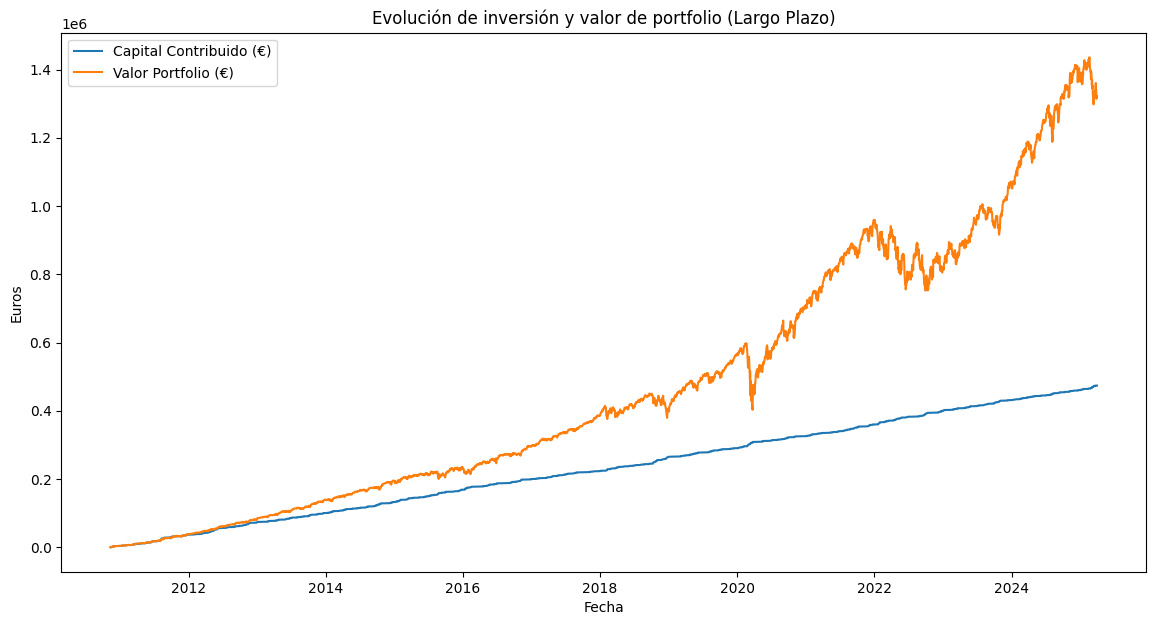

In [37]:
df_resultado = invertir_largo_plazo(df_voo, inversion_fuerte=1000, aporte_semanal=100)

In [33]:
import pandas as pd

def calcular_tasa_exito(df, signal_col, entry_threshold, price_col='close', hold_days=5):
    """
    Calcula la tasa de éxito de las señales de entrada (cuando signal_col cruza entry_threshold).
    
    Args:
        df (pd.DataFrame): DataFrame con columnas de señal y precios. Debe estar ordenado por fecha ascendente.
        signal_col (str): Nombre de la columna que tiene la señal (ej. 'rsi').
        entry_threshold (float): Valor umbral para considerar señal de compra (ej. 30 para RSI sobreventa).
        price_col (str): Nombre de la columna con precios de cierre.
        hold_days (int): Días para evaluar la ganancia después de la entrada.
        
    Returns:
        tasa_exito (float): Porcentaje de entradas ganadoras.
        total_entradas (int): Número total de señales de entrada.
        entradas_ganadoras (int): Número de entradas con ganancia tras hold_days.
    """
    
    df = df.copy()
    df = df.reset_index(drop=True)
    
    entradas = []
    
    for i in range(len(df) - hold_days):
        # Señal de compra: señal menor o igual al umbral (ej: RSI<=30)
        if df.loc[i, signal_col] <= entry_threshold:
            precio_entrada = df.loc[i, price_col]
            precio_salida = df.loc[i + hold_days, price_col]
            ganancia = precio_salida - precio_entrada
            entradas.append(ganancia > 0)  # True si ganó, False si perdió o igual
            
    total_entradas = len(entradas)
    if total_entradas == 0:
        return 0, 0, 0
    
    entradas_ganadoras = sum(entradas)
    tasa_exito = entradas_ganadoras / total_entradas * 100
    
    return tasa_exito, total_entradas, entradas_ganadoras

# Ejemplo de uso con df_voo y RSI
tasa, total, ganadoras = calcular_tasa_exito(df_voo, signal_col='rsi', entry_threshold=30, hold_days=5)
print(f"Tasa de éxito: {tasa:.2f}% ({ganadoras}/{total} entradas ganadoras en {total} entradas totales)")


Tasa de éxito: 84.31% (43/51 entradas ganadoras en 51 entradas totales)


In [25]:
import pandas as pd

def calcular_tasa_exito_multiple(df, indicadores_info, price_col='close', hold_days=5):
    """
    Calcula tasa de éxito para múltiples indicadores con condiciones simples de umbral.
    
    Args:
        df (pd.DataFrame): DataFrame con datos y columnas de indicadores.
        indicadores_info (list of dict): Lista con diccionarios de forma:
            {
                'nombre': 'rsi',
                'tipo': 'umbral',        # 'umbral' o 'cruce' (solo 'umbral' aquí)
                'umbral': 30,            # Umbral para entrada
                'condicion': 'lte'       # 'lte' (<= umbral) o 'gte' (>= umbral)
            }
        price_col (str): Nombre columna de precios para calcular ganancia.
        hold_days (int): Días a futuro para evaluar ganancia.
        
    Returns:
        resultados (dict): { indicador_nombre: { 'tasa_exito': float, 'total_entradas': int, 'entradas_ganadoras': int } }
    """
    resultados = {}
    
    for info in indicadores_info:
        nombre = info['nombre']
        if nombre not in df.columns:
            print(f"Advertencia: indicador '{nombre}' no encontrado en DataFrame.")
            continue
        
        umbral = info.get('umbral')
        condicion = info.get('condicion', 'lte')
        
        entradas = []
        for i in range(len(df) - hold_days):
            valor = df.loc[i, nombre]
            if condicion == 'lte' and valor <= umbral:
                precio_entrada = df.loc[i, price_col]
                precio_salida = df.loc[i + hold_days, price_col]
                ganancia = precio_salida - precio_entrada
                entradas.append(ganancia > 0)
            elif condicion == 'gte' and valor >= umbral:
                precio_entrada = df.loc[i, price_col]
                precio_salida = df.loc[i + hold_days, price_col]
                ganancia = precio_salida - precio_entrada
                entradas.append(ganancia > 0)
        
        total_entradas = len(entradas)
        if total_entradas == 0:
            tasa_exito = 0
            ganadoras = 0
        else:
            ganadoras = sum(entradas)
            tasa_exito = ganadoras / total_entradas * 100
        
        resultados[nombre] = {
            'tasa_exito': tasa_exito,
            'total_entradas': total_entradas,
            'entradas_ganadoras': ganadoras
        }
    
    return resultados

# Ejemplo de uso
indicadores = [
    {'nombre': 'rsi', 'tipo': 'umbral', 'umbral': 30, 'condicion': 'lte'},  # RSI sobreventa
    {'nombre': 'stochastic_k', 'tipo': 'umbral', 'umbral': 20, 'condicion': 'lte'},  # Stochastic sobreventa
    {'nombre': 'bollinger_lband', 'tipo': 'umbral', 'umbral': 80, 'condicion': 'gte'},  # Ejemplo: precio >= banda baja (ajustar según sentido)
]

resultados = calcular_tasa_exito_multiple(df_voo, indicadores, hold_days=5)

for indicador, res in resultados.items():
    print(f"{indicador}: Tasa éxito {res['tasa_exito']:.2f}%, Entradas {res['total_entradas']}, Ganadoras {res['entradas_ganadoras']}")


rsi: Tasa éxito 84.31%, Entradas 51, Ganadoras 43
stochastic_k: Tasa éxito 65.00%, Entradas 440, Ganadoras 286
bollinger_lband: Tasa éxito 61.30%, Entradas 3563, Ganadoras 2184


In [26]:
def detectar_cruces(df, col1, col2):
    """
    Detecta cruces al alza entre col1 y col2.
    Retorna lista booleana con True en fila donde col1 cruza arriba de col2.
    """
    cruces = []
    for i in range(1, len(df)):
        cruza_arriba = (df.loc[i-1, col1] <= df.loc[i-1, col2]) and (df.loc[i, col1] > df.loc[i, col2])
        cruces.append(cruza_arriba)
    cruces.insert(0, False)  # El primer índice no puede tener cruce
    return cruces

def calcular_tasa_exito_multiple_v2(df, indicadores_info, price_col='close', hold_days=5):
    """
    Calcula tasa de éxito para múltiples indicadores con umbrales y cruces.
    
    indicadores_info: lista de dicts con:
        {
            'nombre': 'rsi',
            'tipo': 'umbral' o 'cruce',
            'umbral': 30,           # solo para tipo 'umbral'
            'condicion': 'lte'      # solo para tipo 'umbral': 'lte' o 'gte'
            'col1': 'macd',         # solo para tipo 'cruce'
            'col2': 'macd_signal'   # solo para tipo 'cruce'
        }
    """
    resultados = {}
    
    for info in indicadores_info:
        nombre = info['nombre']
        tipo = info.get('tipo', 'umbral')
        
        if tipo == 'umbral':
            umbral = info.get('umbral')
            condicion = info.get('condicion', 'lte')
            entradas = []
            for i in range(len(df) - hold_days):
                valor = df.loc[i, nombre]
                if condicion == 'lte' and valor <= umbral:
                    precio_entrada = df.loc[i, price_col]
                    precio_salida = df.loc[i + hold_days, price_col]
                    ganancia = precio_salida - precio_entrada
                    entradas.append(ganancia > 0)
                elif condicion == 'gte' and valor >= umbral:
                    precio_entrada = df.loc[i, price_col]
                    precio_salida = df.loc[i + hold_days, price_col]
                    ganancia = precio_salida - precio_entrada
                    entradas.append(ganancia > 0)
            total_entradas = len(entradas)
            ganadoras = sum(entradas) if total_entradas > 0 else 0
            tasa_exito = (ganadoras / total_entradas * 100) if total_entradas > 0 else 0
            
            resultados[nombre] = {
                'tasa_exito': tasa_exito,
                'total_entradas': total_entradas,
                'entradas_ganadoras': ganadoras
            }
            
        elif tipo == 'cruce':
            col1 = info.get('col1')
            col2 = info.get('col2')
            if col1 not in df.columns or col2 not in df.columns:
                print(f"Advertencia: columnas para cruce no encontradas: {col1}, {col2}")
                continue
            
            cruces = detectar_cruces(df, col1, col2)
            entradas = []
            for i in range(len(df) - hold_days):
                if cruces[i]:
                    precio_entrada = df.loc[i, price_col]
                    precio_salida = df.loc[i + hold_days, price_col]
                    ganancia = precio_salida - precio_entrada
                    entradas.append(ganancia > 0)
            total_entradas = len(entradas)
            ganadoras = sum(entradas) if total_entradas > 0 else 0
            tasa_exito = (ganadoras / total_entradas * 100) if total_entradas > 0 else 0
            
            resultados[nombre] = {
                'tasa_exito': tasa_exito,
                'total_entradas': total_entradas,
                'entradas_ganadoras': ganadoras
            }
        else:
            print(f"Tipo no reconocido para {nombre}: {tipo}")
    
    return resultados

# Ejemplo de uso con tus indicadores
indicadores = [
    {'nombre': 'rsi', 'tipo': 'umbral', 'umbral': 30, 'condicion': 'lte'},  # RSI sobreventa
    {'nombre': 'stochastic_k', 'tipo': 'umbral', 'umbral': 20, 'condicion': 'lte'},  # Stochastic sobreventa
    {'nombre': 'bollinger_lband', 'tipo': 'umbral', 'umbral': 80, 'condicion': 'gte'},  # Ejemplo arbitrario
    {'nombre': 'macd_cruce', 'tipo': 'cruce', 'col1': 'macd', 'col2': 'macd_signal'}
]

resultados = calcular_tasa_exito_multiple_v2(df_voo, indicadores, hold_days=5)

for indicador, res in resultados.items():
    print(f"{indicador}: Tasa éxito {res['tasa_exito']:.2f}%, Entradas {res['total_entradas']}, Ganadoras {res['entradas_ganadoras']}")


rsi: Tasa éxito 84.31%, Entradas 51, Ganadoras 43
stochastic_k: Tasa éxito 65.00%, Entradas 440, Ganadoras 286
bollinger_lband: Tasa éxito 61.30%, Entradas 3563, Ganadoras 2184
macd_cruce: Tasa éxito 64.67%, Entradas 150, Ganadoras 97


In [28]:
def simular_inversion_constante_semanal(df, indicadores_info, capital_inicial=0, hold_days=5, inversion_inicial=1000, inversion_semanal=100):
    import numpy as np
    resultados_sim = {}

    # Creamos una lista de fechas de inversión semanal (cada 7 días desde la primera fecha)
    fechas = df['date']
    fecha_inicio = fechas.iloc[0]
    fechas_semanales = [fecha_inicio + pd.Timedelta(days=7*i) for i in range((fechas.iloc[-1] - fecha_inicio).days // 7 + 1)]

    for info in indicadores_info:
        nombre = info['nombre']
        tipo = info.get('tipo', 'umbral')

        # Detectar señales
        if tipo == 'cruce':
            col1 = info.get('col1')
            col2 = info.get('col2')
            if col1 not in df.columns or col2 not in df.columns:
                print(f"Columnas no encontradas para cruce: {col1}, {col2}")
                continue
            señales = detectar_cruces(df, col1, col2)

        elif tipo == 'umbral':
            umbral = info.get('umbral')
            condicion = info.get('condicion', 'lte')
            señales = []
            for i in range(len(df)):
                valor = df.loc[i, nombre]
                if condicion == 'lte':
                    señales.append(valor <= umbral)
                else:
                    señales.append(valor >= umbral)
        else:
            print(f"Tipo no reconocido para {nombre}: {tipo}")
            continue

        capital = capital_inicial
        inversiones = []
        invertido_entrada_inicial = False

        # Invertir 100€ cada semana, independiente de señal
        for fecha_inv in fechas_semanales:
            # Buscar el índice más cercano >= fecha_inv
            idx = df.index[df['date'] >= fecha_inv]
            if len(idx) == 0:
                break
            i = idx[0]

            # Inversión semanal fija
            precio_entrada = df.loc[i, 'close']
            if i + hold_days >= len(df):
                break
            precio_salida = df.loc[i + hold_days, 'close']
            ganancia_relativa = (precio_salida - precio_entrada) / precio_entrada
            ganancia_euros = inversion_semanal * ganancia_relativa
            capital += ganancia_euros
            inversiones.append({
                'fecha_entrada': df.loc[i, 'date'],
                'monto_invertido': inversion_semanal,
                'precio_entrada': precio_entrada,
                'precio_salida': precio_salida,
                'ganancia_euros': ganancia_euros,
                'capital_acumulado': capital
            })

        # Luego invertimos los 1000€ iniciales en la primera señal
        for i in range(len(df) - hold_days):
            if señales[i] and not invertido_entrada_inicial:
                fecha_actual = df.loc[i, 'date']
                precio_entrada = df.loc[i, 'close']
                precio_salida = df.loc[i + hold_days, 'close']
                ganancia_relativa = (precio_salida - precio_entrada) / precio_entrada
                ganancia_euros = inversion_inicial * ganancia_relativa
                capital += ganancia_euros
                inversiones.append({
                    'fecha_entrada': fecha_actual,
                    'monto_invertido': inversion_inicial,
                    'precio_entrada': precio_entrada,
                    'precio_salida': precio_salida,
                    'ganancia_euros': ganancia_euros,
                    'capital_acumulado': capital
                })
                invertido_entrada_inicial = True
                break

        df_inversiones = pd.DataFrame(inversiones).sort_values(by='fecha_entrada').reset_index(drop=True)
        resultados_sim[nombre] = {
            'patrimonio_final': capital,
            'inversiones': df_inversiones
        }

    return resultados_sim



In [29]:
import pandas as pd

def detectar_cruces(df, col1, col2):
    señales = []
    for i in range(1, len(df)):
        prev_diff = df.loc[i-1, col1] - df.loc[i-1, col2]
        curr_diff = df.loc[i, col1] - df.loc[i, col2]
        # Cruce alcista
        if prev_diff <= 0 and curr_diff > 0:
            señales.append(True)
        # Cruce bajista
        elif prev_diff >= 0 and curr_diff < 0:
            señales.append(True)
        else:
            señales.append(False)
    return [False] + señales  # Primer día no hay señal

def simular_inversion_constante_semanal(df, indicadores_info, capital_inicial=0, hold_days=5, inversion_inicial=1000, inversion_semanal=100):
    resultados_sim = {}

    fechas = df['date']
    fecha_inicio = fechas.iloc[0]
    fechas_semanales = [fecha_inicio + pd.Timedelta(days=7*i) for i in range((fechas.iloc[-1] - fecha_inicio).days // 7 + 1)]

    for info in indicadores_info:
        nombre = info['nombre']
        tipo = info.get('tipo', 'umbral')

        # Detectar señales
        if tipo == 'cruce':
            col1 = info.get('col1')
            col2 = info.get('col2')
            señales = detectar_cruces(df, col1, col2)
        elif tipo == 'umbral':
            umbral = info.get('umbral')
            condicion = info.get('condicion', 'lte')
            señales = []
            for i in range(len(df)):
                valor = df.loc[i, nombre]
                if condicion == 'lte':
                    señales.append(valor <= umbral)
                else:
                    señales.append(valor >= umbral)
        else:
            print(f"Tipo no reconocido para {nombre}: {tipo}")
            continue

        capital = capital_inicial
        inversiones = []
        invertido_entrada_inicial = False

        # Invertir 100€ cada semana (fijo)
        for fecha_inv in fechas_semanales:
            idx = df.index[df['date'] >= fecha_inv]
            if len(idx) == 0:
                break
            i = idx[0]

            precio_entrada = df.loc[i, 'close']
            if i + hold_days >= len(df):
                break
            precio_salida = df.loc[i + hold_days, 'close']
            ganancia_relativa = (precio_salida - precio_entrada) / precio_entrada
            ganancia_euros = inversion_semanal * ganancia_relativa
            capital += ganancia_euros
            inversiones.append({
                'fecha_entrada': df.loc[i, 'date'],
                'monto_invertido': inversion_semanal,
                'precio_entrada': precio_entrada,
                'precio_salida': precio_salida,
                'ganancia_euros': ganancia_euros,
                'capital_acumulado': capital,
                'indicador': nombre
            })

        # Invertir 1000€ en la primera señal
        for i in range(len(df) - hold_days):
            if señales[i] and not invertido_entrada_inicial:
                fecha_actual = df.loc[i, 'date']
                precio_entrada = df.loc[i, 'close']
                precio_salida = df.loc[i + hold_days, 'close']
                ganancia_relativa = (precio_salida - precio_entrada) / precio_entrada
                ganancia_euros = inversion_inicial * ganancia_relativa
                capital += ganancia_euros
                inversiones.append({
                    'fecha_entrada': fecha_actual,
                    'monto_invertido': inversion_inicial,
                    'precio_entrada': precio_entrada,
                    'precio_salida': precio_salida,
                    'ganancia_euros': ganancia_euros,
                    'capital_acumulado': capital,
                    'indicador': nombre
                })
                invertido_entrada_inicial = True
                break

        df_inversiones = pd.DataFrame(inversiones).sort_values(by='fecha_entrada').reset_index(drop=True)

        # Métricas de efectividad
        total_operaciones = len(df_inversiones)
        ganancia_total = df_inversiones['ganancia_euros'].sum()
        operaciones_ganadoras = df_inversiones[df_inversiones['ganancia_euros'] > 0]
        tasa_exito = len(operaciones_ganadoras) / total_operaciones if total_operaciones > 0 else 0

        print(f"\nIndicador: {nombre}")
        print(f"Total operaciones: {total_operaciones}")
        print(f"Ganancia/pérdida total: {ganancia_total:.2f} €")
        print(f"Tasa de éxito: {tasa_exito:.2%}")
        print(f"Patrimonio final: {capital:.2f} €")

        resultados_sim[nombre] = {
            'patrimonio_final': capital,
            'df_inversiones': df_inversiones,
            'tasa_exito': tasa_exito,
            'ganancia_total': ganancia_total,
            'total_operaciones': total_operaciones
        }

    return resultados_sim


In [30]:
indicadores_info = [
    {'nombre': 'rsi', 'tipo': 'umbral', 'umbral': 30, 'condicion': 'lte'},  # Comprar cuando RSI <= 30
    {'nombre': 'macd', 'tipo': 'cruce', 'col1': 'macd', 'col2': 'macd_signal'},  # Señales por cruce MACD
    # Añade más indicadores según tus columnas y condiciones
]


In [31]:
resultados = simular_inversion_constante_semanal(df_voo, indicadores_info, hold_days=5)



Indicador: rsi
Total operaciones: 751
Ganancia/pérdida total: 183.33 €
Tasa de éxito: 58.85%
Patrimonio final: 183.33 €

Indicador: macd
Total operaciones: 751
Ganancia/pérdida total: 228.93 €
Tasa de éxito: 58.99%
Patrimonio final: 228.93 €
